# U-Net pour la colorisation d'images
Projet de colorisation d'images à niveaux de gris par deep learning.  
Implémentation d'un d'un réseau CNN simple au format U-Net pour la prédiction des canaux RGB à partir d'images à niveaux de gris.  
Utilisation de PyTorch avec le dataset CIFAR-10.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np

/home/greg7/S9/env/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


## Création du modèle U-Net

In [2]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        self.encoder1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(2)
        
        self.encoder2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(2)
        
        self.middle = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        self.final = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 3, kernel_size=1)
        )

    def forward(self, x):
        # Encodeur
        enc1 = self.encoder1(x)
        enc1_pool = self.pool1(enc1)
        
        enc2 = self.encoder2(enc1_pool)
        enc2_pool = self.pool2(enc2)
        
        middle = self.middle(enc2_pool)
        
        # Decodeur
        up2 = self.upconv2(middle)
        dec2 = self.decoder2(torch.cat([up2, enc2], dim=1))
        
        up1 = self.upconv1(dec2)
        dec1 = self.decoder1(torch.cat([up1, enc1], dim=1))
        
        # Sortie
        out = self.final(dec1)
        
        return out

In [14]:
nn.Conv2d?

Init signature:
nn.Conv2d(
    in_channels: int,
    out_channels: int,
    kernel_size: Union[int, Tuple[int, int]],
    stride: Union[int, Tuple[int, int]] = 1,
    padding: Union[str, int, Tuple[int, int]] = 0,
    dilation: Union[int, Tuple[int, int]] = 1,
    groups: int = 1,
    bias: bool = True,
    padding_mode: str = 'zeros',
    device=None,
    dtype=None,
) -> None
Docstring:     
Applies a 2D convolution over an input signal composed of several input
planes.

In the simplest case, the output value of the layer with input size
:math:`(N, C_{\text{in}}, H, W)` and output :math:`(N, C_{\text{out}}, H_{\text{out}}, W_{\text{out}})`
can be precisely described as:

.. math::
    \text{out}(N_i, C_{\text{out}_j}) = \text{bias}(C_{\text{out}_j}) +
    \sum_{k = 0}^{C_{\text{in}} - 1} \text{weight}(C_{\text{out}_j}, k) \star \text{input}(N_i, k)


where :math:`\star` is the valid 2D `cross-correlation`_ operator,
:math:`N` is a batch size, :math:`C` denotes a number of channels,
:

## Traitement du dataset CIFAR-10

In [3]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

# Charger les données CIFAR-10
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Préparer les labels (images originales)
train_labels = datasets.CIFAR10(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_labels = datasets.CIFAR10(root='./data', train=False, transform=transforms.ToTensor(), download=True)

train_labels_loader = DataLoader(train_labels, batch_size=32, shuffle=True)
test_labels_loader = DataLoader(test_labels, batch_size=32, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## Fonction d'entraînement

In [4]:
def train_model(model, train_loader, train_labels_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for (inputs, _), (targets, _) in zip(train_loader, train_labels_loader):            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}')

## Fonction de validation

In [5]:
def validate_model(model, test_loader, test_labels_loader, criterion):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for (inputs, _), (targets, _) in zip(test_loader, test_labels_loader):
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            val_loss += loss.item() * inputs.size(0)
    
    val_loss /= len(test_loader.dataset)
    print(f'Validation Loss: {val_loss:.4f}')

## Entraînement et validation du modèle

In [6]:
# Initialiser le modèle, la perte et l'optimiseur
model = UNet()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entraîner le modèle
train_model(model, train_loader, train_labels_loader, criterion, optimizer, num_epochs=2)

# Valider le modèle
validate_model(model, test_loader, test_labels_loader, criterion)

Epoch 0/1, Loss: 0.0635
Epoch 1/1, Loss: 0.0623
Validation Loss: 0.0615


**Commentaires**  
Uniquement 2 époques pour tester rapidement pour car entraînement sur CPU pour le moment.  
Taux d'apprentissage à adapter également.

## Test du modèle

In [7]:
def get_test_images(test_loader, test_labels_loader, num_images=5):
    test_images = []
    test_labels = []
    for (inputs, _), (targets, _) in zip(test_loader, test_labels_loader):
        test_images.extend(inputs[:num_images])
        test_labels.extend(targets[:num_images])
        if len(test_images) >= num_images:
            break
    return torch.stack(test_images), torch.stack(test_labels)

num_test_images = 5
test_images, test_labels = get_test_images(test_loader, test_labels_loader, num_images=num_test_images)

In [8]:
model.eval()
with torch.no_grad():
    predicted_images = model(test_images)

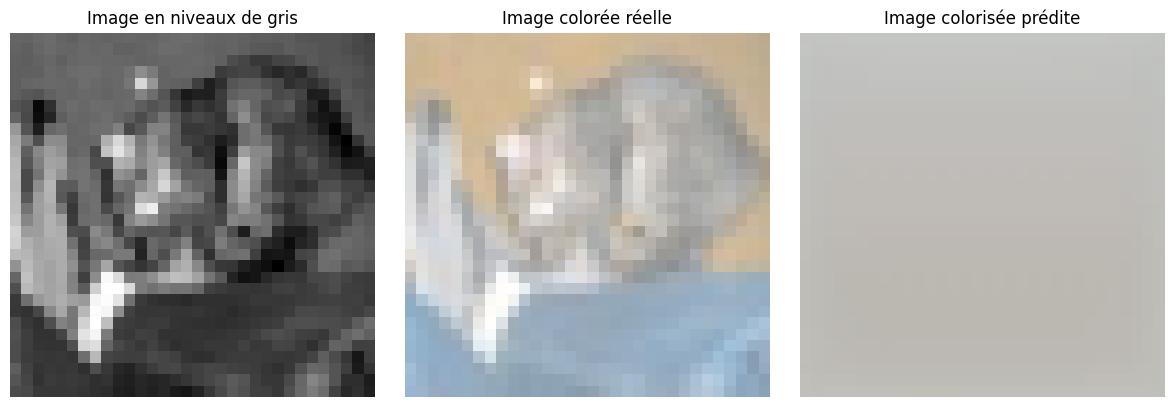

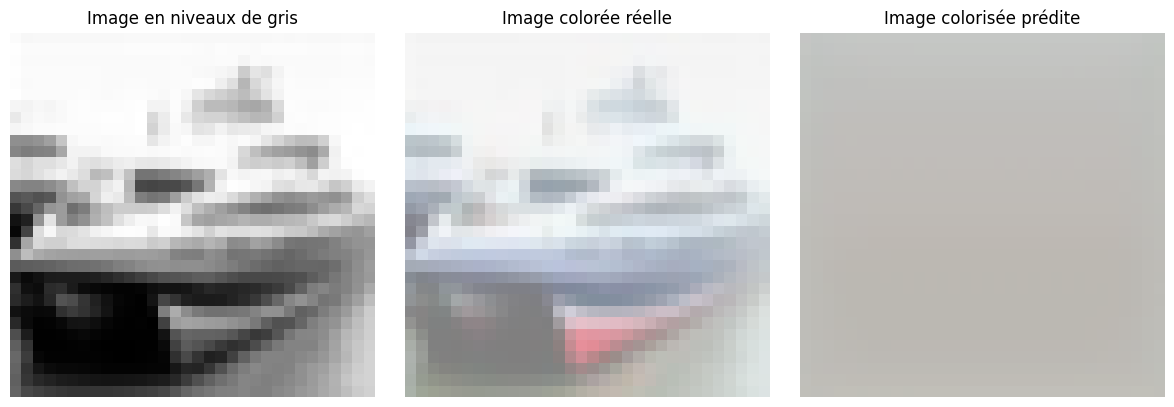

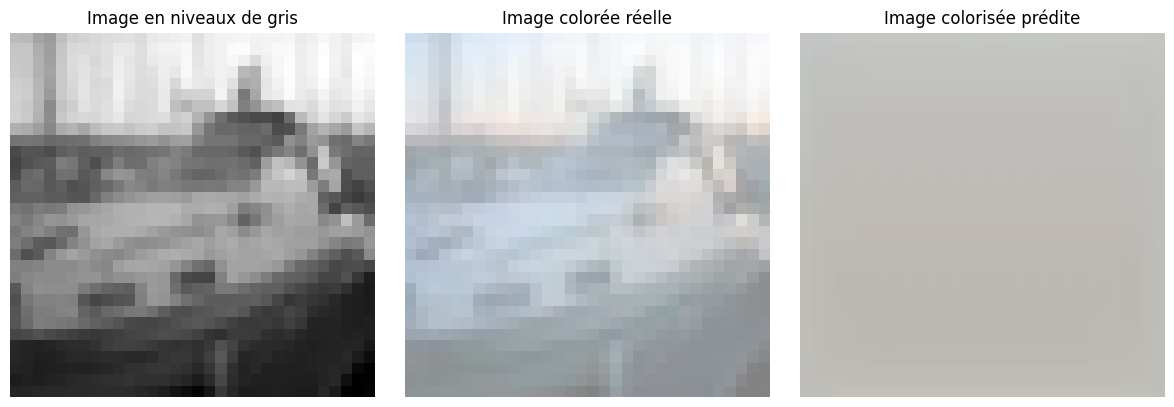

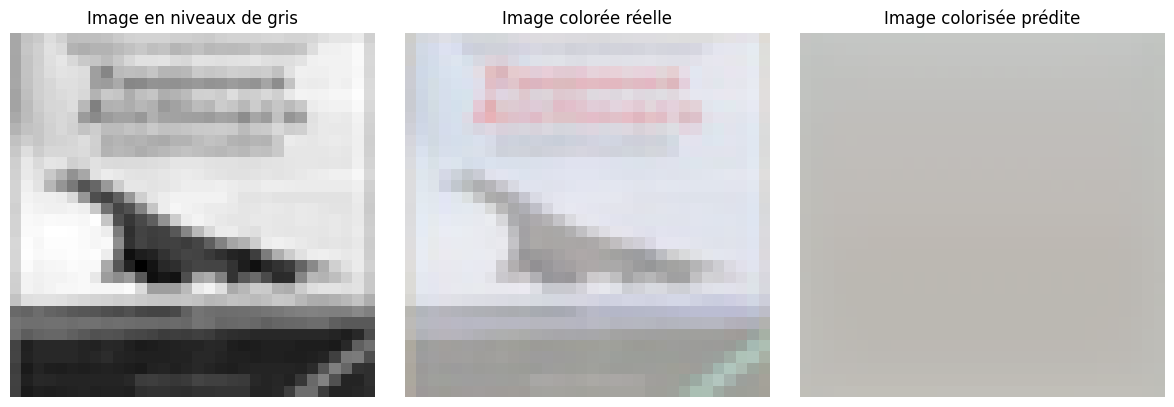

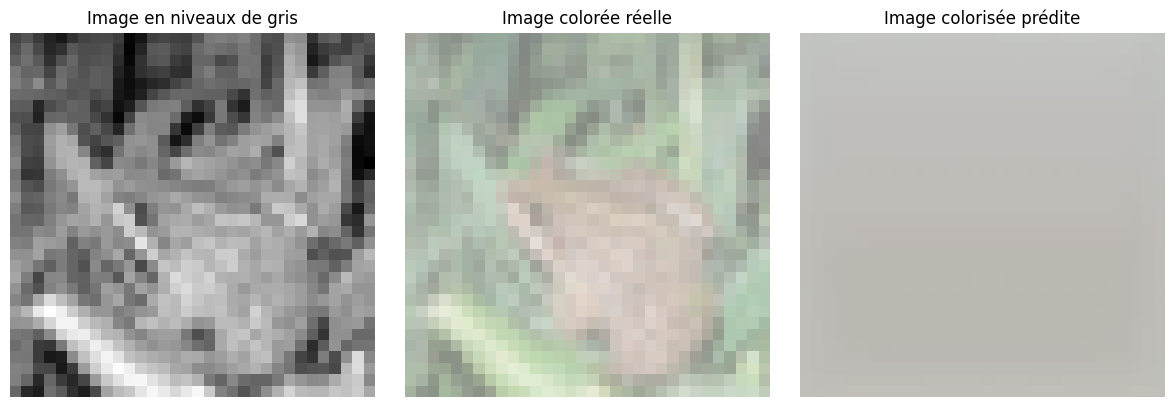

In [13]:
def pre_imshow(img):
    img = img / 2 + 0.5  # dénormaliser
    return img.numpy()

for i in range(num_test_images):
    # Créer une figure avec une grille 1x3 de sous-graphiques
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

    # Afficher l'image en niveaux de gris (test_images[i])
    npimg = test_images[i]
    ax1.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    ax1.set_title('Image en niveaux de gris')
    ax1.axis('off')
    
    # Afficher l'image colorée réelle (test_labels[i])
    npimg = pre_imshow(test_labels[i])
    ax2.imshow(np.transpose(npimg, (1, 2, 0)))
    ax2.set_title('Image colorée réelle')
    ax2.axis('off')
    
    # Afficher l'image colorisée prédite (predicted_images[i])
    npimg = pre_imshow(predicted_images[i])
    ax3.imshow(np.transpose(npimg, (1, 2, 0)))
    ax3.set_title('Image colorisée prédite')
    ax3.axis('off')
    
    # Ajuster l'espacement entre les sous-graphiques pour éviter le chevauchement
    plt.tight_layout()

    # Afficher la figure complète pour cet exemple
    plt.show()

**Commentaire**  
Echec pour le moment.  
Revoir l'architecture du modèle U-Net et le traitement des données.  
Réaliser l'entrainement sur GPU avec plus d'époques.